### **Trabalho 1 - Aprendizado de Máquina para Séries Temporais**

Ada Máris Pereira Mário - Nº USP: 12725432.

Gabriela dos Santos Amaral Nº USP: 13749681.

Jonas Santos Siqueira - Nº USP: 13989752.

#### Pacotes:

In [ ]:
# Instalar as novas bibliotecas:
!pip install wfdb
!pip install stumpy

In [ ]:
import os
import wfdb
import stumpy
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from bokeh.layouts import gridplot
from scipy.signal import find_peaks
from bokeh.io import output_notebook
from bokeh.models import Span, Label
from bokeh.plotting import figure, show

In [ ]:
output_notebook()

### Baixar a base de dados EDB (European ST-T Database):

O processo pode demorar em torno de 15 a 30 minutos (vai depender muito da sua conexão de banda larga).

In [ ]:
dbs = wfdb.get_dbs()

# Baixar a base de dados 'edb' (European ST-T Database) do PhysioNet:
edb_dir = os.path.join(os.getcwd(), 'edb_dir')
wfdb.dl_database('edb', dl_dir = edb_dir)

edb_in_files = [os.path.splitext(f)[0] for f in os.listdir(edb_dir) if f.endswith('.dat')]

#### Processando os dados:

### **Focado nos Eventos ST e T**:

In [ ]:
# Listar os arquivos baixados
edb_files = [os.path.splitext(f)[0] for f in os.listdir(edb_dir) if f.endswith('.dat')]

# Configurações de processamento
time_window = 250  # Janela de 1 segundo (250 amostras)
all_events = []
patient_info = []

# Processar cada arquivo .dat na base de dados
for edb_file in edb_files:
    print(f'Processando arquivo: {edb_file}')

    # Ler o sinal e os campos do cabeçalho
    record_path = os.path.join(edb_dir, edb_file)
    signal, fields = wfdb.rdsamp(record_path, channels=[0, 1])  # Dois canais de ECG

    # Ler as informações de cabeçalho
    header = wfdb.rdheader(record_path)
    patient_info.append({
        "record": edb_file,
        "age": header.comments[1] if len(header.comments) > 1 else "Unknown",
        "gender": header.comments[0] if len(header.comments) > 0 else "Unknown",
        "diagnosis": header.comments[2] if len(header.comments) > 2 else "Unknown"
    })

    # Ler as anotações da base de dados
    annotations = wfdb.rdann(record_path, 'atr')

    # Processar eventos de alteração no ST e T
    signal = np.array(signal[:, 0]).flatten()  # Usando o canal 0
    for ann_symbol, ann_sample in zip(annotations.symbol, annotations.sample):
        # Extraímos uma janela em torno de cada evento de interesse
        if ann_symbol in ['N','a','J','S','V','F','Q','|','T','•']:  # <--- categorias.
            event_window = signal[ann_sample - time_window:ann_sample + time_window]
            all_events.append({
                'event_type': ann_symbol,
                'signal_data': event_window,
                'record': edb_file
            })

# Converter os dados de eventos para um DataFrame do pandas
event_df = pd.DataFrame(all_events)

* Salvar os dados em um arquivo CSV:

In [ ]:
output_path_events = os.path.join(os.getcwd(), 'eventos_edb.xlsx')
event_df.to_excel(output_path_events, index=False)

print(f"Dados salvos em: {output_path_events}")

#### Usando O Matrix Profile:




* Utilizando a base pandas gerada e filtrando o paciente `e0104`:

In [ ]:
# Expandir as séries temporais em formato longo:
e0104 = event_df[event_df['record'] == 'e0104'].explode("signal_data").reset_index().iloc[:10_000]

# Criar o índice temporal para cada série:
e0104['time_index'] = e0104.groupby(['event_type', 'record']).cumcount()
e0104.head()

,index,event_type,signal_data,record,time_index
0,211815,N,NaN,e0104,0
1,211816,N,NaN,e0104,1
2,211817,N,-1.165,e0104,2
3,211817,N,-1.155,e0104,3
4,211817,N,-1.155,e0104,4


Plot da série:

<Axes: >

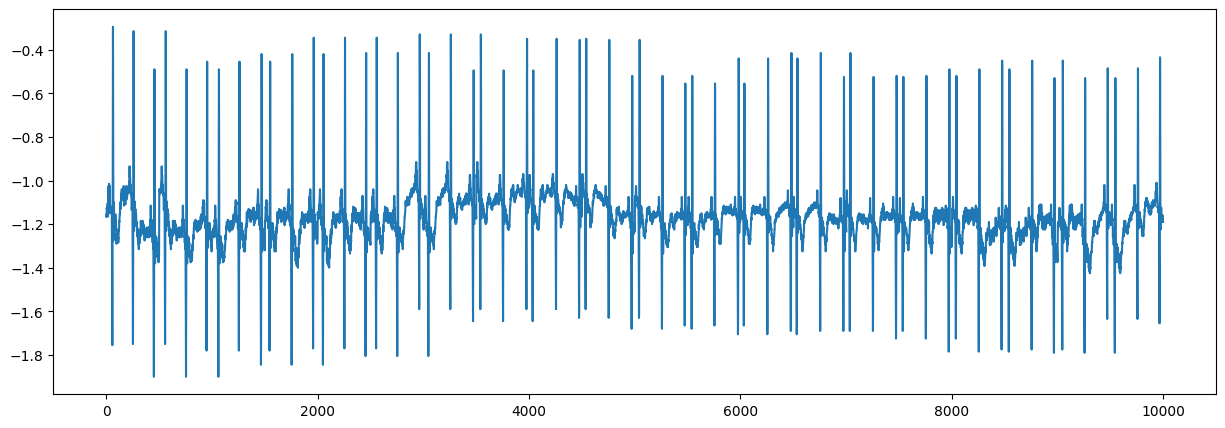

In [ ]:
e0104['signal_data'].plot(figsize=(15, 5))

* Separando os dados:

In [ ]:
data_real = np.array(e0104['signal_data'], dtype=float)
time_real = np.array(e0104['time_index'], dtype=float)

* Determinando o Valor de `m` usando o Intervalo RR Médio:

In [ ]:
# Taxa de amostragem:
sampling_rate = 250  # Hz

# Encontrar picos R:
peaks, _ = find_peaks(data_real, distance=sampling_rate*0.5)  # 0.5s é o mínimo entre batimentos.

# Calcular intervalos RR:
rr_intervals = np.diff(peaks) / sampling_rate  # em segundos.

# Duração média de um batimento:
mean_rr = np.mean(rr_intervals)
print(f'Duração média de um batimento: {mean_rr:.2f} segundos')

# Ajustar m com base no intervalo RR médio:
m = int(mean_rr * sampling_rate)
print(f'Valor de m (em amostras): {m}')

Duração média de um batimento: 0.67 segundos
Valor de m (em amostras): 167


In [ ]:
# Duração típica do segmento ST-T em segundos:
st_t_duration = 0.3  # <-- segundos.

# Calculando m:
m = int(st_t_duration * sampling_rate)
print(f'Valor de m: {m}')

Valor de m: 75


* Utilizando o tamanho de `m` encontrado no código acima para calcular o Matrix Profile:

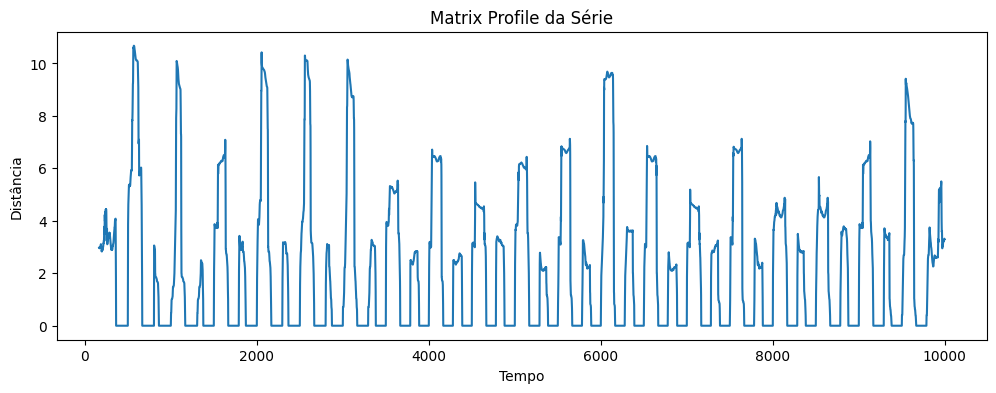

In [ ]:
m = 167  # <-- Tamanho da janela (m).

# Calcular o matrix profile:
mp_real = stumpy.stump(data_real.astype(float), m)
matrix_profile_real = mp_real[:, 0] # <-- Distâncias Calculadas.

# Visualizar o matrix profile:
plt.figure(figsize=(12, 4))
plt.plot(time_real[m - 1:], matrix_profile_real)
plt.title('Matrix Profile da Série')
plt.xlabel('Tempo')
plt.ylabel('Distância')
plt.show()

* Encontrando as `Anomalias`:

In [ ]:
# Transformando o calculo das distâncias em Array para evitar erros:
matrix_profile_real = np.array(matrix_profile_real, dtype=float)

# Calcular média e desvio padrão do matrix profile:    <-- O motivo de usar a médiana e o desvio padrão absoluto, é pq a mediana e o MAD não são sensiveis a Outliers.
mp_median = np.median(matrix_profile_real)
mp_mad = np.median(np.abs(matrix_profile_real - mp_median))

# Definir o limiar:
threshold = mp_median + 3 * mp_mad

# Identificar as posições onde o matrix profile excede o limiar:
anomaly_indices = np.where(matrix_profile_real > threshold)[0]

# Remover índices redundantes (próximos entre si):
from scipy.signal import find_peaks

peaks, _ = find_peaks(matrix_profile_real, height=threshold, distance=m)

In [ ]:
# Gráfico 1: Série temporal com anomalias detectadas.
p1 = figure(title="Série Temporal com Anomalias Detectadas",
            x_axis_label="Tempo",
            y_axis_label="Valor",
            width=1400,
            height=350)

p1.title.text_font_size = "16pt"
p1.line(time_real, data_real, line_width=2)
p1.scatter([time_real[i] for i in peaks],
            [data_real[i] for i in peaks],
            size=8, color="red", legend_label="Anomalias")

p1.legend.location = "top_left"
p1.legend.orientation = "horizontal"

# Gráfico 2: Matrix Profile e Limiar de Anomalia.
p2 = figure(title="Matrix Profile e Limiar de Anomalia",
            x_axis_label="Posição",
            y_axis_label="Distância",
            width=1400,
            height=250)

p2.title.text_font_size = "16pt"
p2.line(list(range(len(matrix_profile_real))), matrix_profile_real, line_width=2)
p2.scatter(peaks, [matrix_profile_real[i] for i in peaks], size=8, color="red")

threshold_span = Span(location=threshold, dimension='width', line_color='red', line_dash='dashed', line_width=2)
p2.add_layout(threshold_span)

label = Label(x=-400, y=threshold, text="Limiar", text_color="red", text_font_size="10pt")
p2.add_layout(label)

layout = gridplot([[p1], [p2]])
show(layout)

Obs.: No GitHub o gráfico não aparece, por isso, para acessar o gráfico gerado pelo código anterior, acesse: https://drive.google.com/file/d/1ok6DdK8f-fIds6Td1xW_AFBaUj8haA4I/view?usp=sharing

* Encontrando os `discords`:

In [ ]:
# Número de discords para encontrar:
num_discords = 15

# Copiar o matrix profile para não alterar o original:
mp_copy = matrix_profile_real.copy()

discords = []
for _ in range(num_discords):
    # Encontrar o índice do maior valor no matrix profile:
    discord_idx = np.argmax(mp_copy)
    discords.append(discord_idx)

    # Excluir a vizinhança para evitar encontrar o mesmo discord:
    exclusion_zone = int(m / 2)
    start = max(0, discord_idx - exclusion_zone)
    end = min(len(mp_copy), discord_idx + exclusion_zone)
    mp_copy[start:end] = -np.inf  # Excluir zona.

In [ ]:
p1 = figure(title="Série Temporal com Discords Identificados",
            x_axis_label="Tempo",
            y_axis_label="Valor",
            width=1100,
            height=400)

p1.title.text_font_size = "16pt"
p1.line(time_real, data_real, line_width=2)
p1.scatter([time_real[i] for i in discords],
            [data_real[i] for i in discords ],
            size=8, color="red", legend_label="Discords")

p1.legend.location = "top_left"
p1.legend.orientation = "horizontal"

layout = gridplot([[p1]])
show(layout)

Obs.: No GitHub o gráfico não aparece, por isso, para acessar o gráfico gerado pelo código anterior, acesse: https://drive.google.com/file/d/13xQqx8nm2gBTFlLg8WWvJXGagvCVZKeZ/view?usp=sharing